# Install Packages

In [70]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import json
from shapely.validation import make_valid
import warnings

# Read Files

In [2]:
data = pd.read_json("data/cleaned/BusRoutes.json", encoding="utf-8", lines=True, chunksize=1000)

# Combine chunks into a dataframe
df_list = []
for chunk in data:
    df_list.append(chunk)

# Concatenate all chunks into a single dataframe
bus_routes = pd.concat(df_list, ignore_index=True)
bus_routes = bus_routes[bus_routes['Direction']==1]
bus_routes = bus_routes[['ServiceNo', 'BusStopCode', 'StopSequence', 'Distance']]
print(bus_routes.head())

  ServiceNo  BusStopCode  StopSequence  Distance
0        10        75009             1       0.0
1        10        76059             2       0.6
2        10        76069             3       1.1
3        10        96289             4       2.3
4        10        96109             5       2.7


In [3]:
# Load BusStops.geojson using GeoPandas
bus_stops = gpd.read_file('data/cleaned/BusStops.geojson').to_crs(32648)
print(bus_stops.head())

   BUS_STOP_N BUS_ROOF_N         LOC_DESC                       geometry
0       65059        B12     ST ANNE'S CH   POINT (377770.78 154000.188)
1       16171        B06  YUSOF ISHAK HSE  POINT (363642.782 143603.062)
2       61101        NIL          BLK 120  POINT (373583.973 147657.504)
3        1239        B01     SULTAN PLAZA   POINT (373353.81 144032.943)
4       17269        B01          BLK 730  POINT (362337.597 144267.297)


In [4]:
rail_line = gpd.read_file('data/cleaned/RailLines.geojson').to_crs(32648)
print(rail_line.head())

    Name                                        Description  GroundLevel  \
0  kml_1  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   
1  kml_2  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   
2  kml_3  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   
3  kml_4  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   
4  kml_5  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   

  RailType                                           geometry  
0      MRT  LINESTRING Z (359431.624 149585.058 0, 359430....  
1      MRT  LINESTRING Z (359496.358 149434.165 0, 359562....  
2      MRT  LINESTRING Z (356848.064 149532.756 0, 356847....  
3      MRT  LINESTRING Z (356839.113 149546.331 0, 356837....  
4      MRT  LINESTRING Z (356223.133 149130.489 0, 356223....  


In [5]:
rail_stn = gpd.read_file('data/cleaned/RailStationsMerged.geojson').to_crs(32648)
print(rail_stn.head())

      Name                                        Description StationType  \
0  kml_105  <center><table><tr><th colspan='2' align='cent...         MRT   
1  kml_154  <center><table><tr><th colspan='2' align='cent...         MRT   
2    kml_1  <center><table><tr><th colspan='2' align='cent...         MRT   
3  kml_163  <center><table><tr><th colspan='2' align='cent...         MRT   
4  kml_243  <center><table><tr><th colspan='2' align='cent...         MRT   

      StationName StationCode    StationLine  \
0       Admiralty        NS10    North-South   
1        Aljunied         EW9      East-West   
2      Ang Mo Kio        NS16    North-South   
3   Aviation Park         CR2   Cross Island   
4  Bahar Junction         JS7  Jurong Region   

                                            geometry  
0  POLYGON Z ((366516.031 159202.829 0, 366504.93...  
1  POLYGON Z ((375812.204 145533.073 0, 375813.17...  
2  POLYGON Z ((372048.497 151373.847 0, 372034.48...  
3  POLYGON Z ((388984.94 151

# Data Cleaning : Obtain  Bus Line Strings

In [6]:
## Merge Bus Stop Coordinates with Bus Routes
# Ensure that BusStopCode is of the same type for both DataFrames (string)
bus_stops['BusStopCode'] = bus_stops['BUS_STOP_N'].astype(str)
bus_routes['BusStopCode'] = bus_routes['BusStopCode'].astype(str)

# Merge bus_routes with bus_stops to get geometry for each bus stop
merged_bus_data = bus_routes.merge(bus_stops[['BusStopCode', 'geometry']], on='BusStopCode', how='left')

# Drop rows without geometry
merged_bus_data = merged_bus_data.dropna(subset=['geometry'])

# Convert to GeoDataFrame
bus_routes_geo = gpd.GeoDataFrame(merged_bus_data, geometry='geometry')
# bus_routes_geo.to_crs(3857)
bus_routes_geo.set_crs(epsg=32648, inplace=True,allow_override=True)
bus_routes_geo.head()

,ServiceNo,BusStopCode,StopSequence,Distance,geometry
0,10,75009,1,0.0,POINT (382479.99 149772.212)
1,10,76059,2,0.6,POINT (382257.146 149576.907)
2,10,76069,3,1.1,POINT (382307.904 149087.517)
3,10,96289,4,2.3,POINT (383004.155 148143.843)
4,10,96109,5,2.7,POINT (383262.649 147839.518)


# Segment Bus Routes by LineString


  ServiceNo                                           geometry
0        10  LINESTRING (382479.99 149772.212, 382257.146 1...
1       100  LINESTRING (374479.342 149295.696, 374511.914 ...
2      100A  LINESTRING (374479.342 149295.696, 374511.914 ...
3       101  LINESTRING (374479.342 149295.696, 374602.888 ...
4       102  LINESTRING (376740.13 151559.417, 377110.624 1...


/var/folders/hx/j3t1dc5d6539d5c6zm67rnf00000gn/T/ipykernel_71113/2572441167.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bus_routes_geo.groupby(['ServiceNo'])


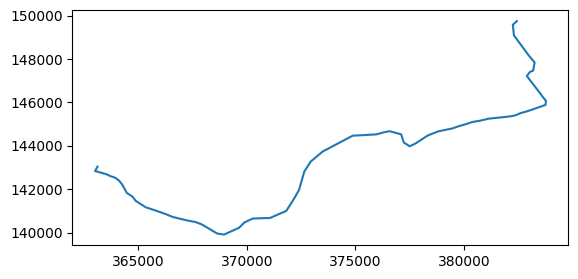

In [7]:
bus_routes_lines = (
    bus_routes_geo.groupby(['ServiceNo'])
    .apply(lambda x: LineString(x.sort_values('StopSequence')['geometry'].tolist()))
    .reset_index()
    .rename(columns={0: 'geometry'})
)
# Convert to GeoDataFrame
bus_routes_lines = gpd.GeoDataFrame(bus_routes_lines, geometry='geometry')
bus_routes_lines = bus_routes_lines.set_crs(epsg=32648)
print(bus_routes_lines.head())

bs10 = bus_routes_lines[bus_routes_lines['ServiceNo']=='10']

bs10.plot()
plt.show()

# Visualise Bus Segments

[<LINESTRING (382479.99 149772.212, 382433.572 148917.191)>, <LINESTRING (382433.572 148917.191, 383029.365 148114.162)>, <LINESTRING (383029.365 148114.162, 382985.657 147324.761)>, <LINESTRING (382985.657 147324.761, 383429.033 146530.459)>, <LINESTRING (383429.033 146530.459, 383545.178 145805.014)>, <LINESTRING (383545.178 145805.014, 382594.422 145496.484)>, <LINESTRING (382594.422 145496.484, 381621.979 145298.007)>, <LINESTRING (381621.979 145298.007, 380636.986 145135.189)>, <LINESTRING (380636.986 145135.189, 379675.138 144869.186)>, <LINESTRING (379675.138 144869.186, 378709.364 144619.358)>, <LINESTRING (378709.364 144619.358, 377835.07 144144.303)>, <LINESTRING (377835.07 144144.303, 377137.661 144439.482)>, <LINESTRING (377137.661 144439.482, 376227.297 144595.115)>, <LINESTRING (376227.297 144595.115, 375238.054 144481.901)>, <LINESTRING (375238.054 144481.901, 374312.143 144165.987)>, <LINESTRING (374312.143 144165.987, 373436.091 143686.869)>, <LINESTRING (373436.091 14

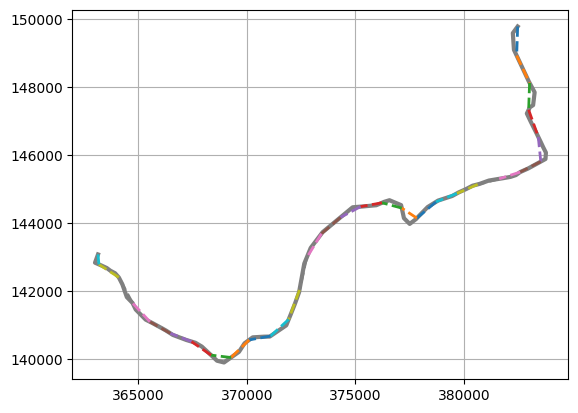

In [8]:
def segment_line_by_distance(line, distance=1000):
    segments = []  # List to store the line segments
    current_distance = 0  # Start distance

    # Iterate over the entire length of the line and create segments of the specified distance
    while current_distance < line.length:
        # Calculate the start and end points for each segment
        start_point = line.interpolate(current_distance)
        end_point = line.interpolate(min(current_distance + distance, line.length))
        
        # Create a LineString for the segment and add it to the list
        segments.append(LineString([start_point, end_point]))
        
        # Move to the next segment
        current_distance += distance

    return segments  # Return the list of 1 km line segments

# Segment the line by 1 km distance
bs10_segmented = segment_line_by_distance(bs10.geometry.iloc[0], 1000)
print(bs10_segmented)
# plot orignal bus line
x, y = bs10.geometry.iloc[0].xy  # Extract x and y coordinates for the original line
plt.plot(x, y, color='gray', linewidth=3, label='Original Bus Line')

# plot segmented bus line
for segment in bs10_segmented:
    x_seg, y_seg = segment.xy  # Extract x and y coordinates for the segment
    plt.plot(x_seg, y_seg, linewidth=2, linestyle='--')

# Show the plot
plt.grid(True)
plt.show()

# Create MRT Line String with MRT Stations

In [23]:
rail_stn = rail_stn.to_crs(epsg=32648)

#  Group the stations by MRT line
rail_stn.drop(rail_stn[rail_stn['StationCode']=='PTC'].index, inplace=True)
rail_stn.drop(rail_stn[rail_stn['StationCode']=='STC'].index, inplace=True)
rail_stn.replace("TE22A", "TE22.5", inplace=True)

station_groups = rail_stn.groupby('StationLine')

# Dictionary to store LineStrings for each MRT line
line_strings_per_station_line = {}

# Iterate over each MRT line group and create a sorted LineString
for line_name, group in station_groups:
    line_strings_per_station_line[line_name] = []

    # Sort the stations by their longitude (x-coordinate) or latitude (y-coordinate)
    group['centroid_x'] = group.geometry.centroid.x  # Get x-coordinate of the centroid
    group['StationCodeNo'] = group['StationCode'].str[2:].astype(float) # extracts the number from the station code
    group['StationCodeSymbol'] = group['StationCode'].str[:2]

    unique_station_symbols = group['StationCodeSymbol'].unique()

    for symbol in unique_station_symbols:

        symbol_group = group[group['StationCodeSymbol']==symbol]
        sorted_group = symbol_group.sort_values('StationCodeNo')  

        # Extract the station centroids, names, and codes
        station_points = sorted_group.geometry.centroid.tolist()
        station_names = sorted_group['StationName'].tolist()
        station_codes = sorted_group['StationCode'].tolist()

        # Initialize a set to track unique station codes
        unique_station_codes = set()

        # Initialize lists to store filtered stations (with unique codes)
        filtered_station_points = []
        filtered_station_names = []
        filtered_station_codes = []

        #Filter out stations with duplicate station codes and None values
        for point, name, code in zip(station_points, station_names, station_codes):
            if code not in unique_station_codes and point is not None:
                # Add the station to the filtered lists
                filtered_station_points.append(point)
                filtered_station_names.append(name)
                filtered_station_codes.append(code)

                # Mark this station code as seen
                unique_station_codes.add(code)

        # NOTE (JJ): The dataset is incomplete, for example, Pasir Ris being CR5 in 
        # Cross Island is not there, and there are symbols with only 1 station. 
        # LineStrings cannot be formed for single stations so we skip them for now

        # create a LineString from the filtered station points
        if filtered_station_points:  # Check if we have valid points
            if len(filtered_station_points) == 1:
                print(f"Skipping {line_name} {symbol} as it only has 1 station")
                continue
            try:
                mrt_line = LineString(filtered_station_points)
            
                # append the list to the dictionary item
                line_strings_per_station_line[line_name].append({
                    'LineString': mrt_line,
                    'StationNames': filtered_station_names,
                    'StationCodes': filtered_station_codes,
                    'StationPoints': filtered_station_points
                })
            except TypeError as e:
                print(f"Error creating LineString for {line_name}: {e}")
                continue

print(line_strings_per_station_line)
for line_name, line_data in line_strings_per_station_line.items():
    print(f"MRT Line: {line_name}")
    for stn_symbol_data in line_data:
        print(f"  LineString: {stn_symbol_data['LineString']}")
        print(f"  Station Names: {stn_symbol_data['StationNames']}")
        print(f"  Station Codes: {stn_symbol_data['StationCodes']}")
        print(f"  Station Points (centroids): {stn_symbol_data['StationPoints']}")
        print("\n")

Skipping Cross Island CP as it only has 1 station
{'Bukit Panjang LRT': [{'LineString': <LINESTRING (360309.027 153140.435, 360411.414 152601.551, 360829.656 152414...>, 'StationNames': ['Choa Chu Kang', 'South View', 'Keat Hong', 'Teck Whye', 'Phoenix', 'Bukit Panjang', 'Petir', 'Pending', 'Bangkit', 'Fajar', 'Segar', 'Senja'], 'StationCodes': ['BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'BP8', 'BP9', 'BP10', 'BP11', 'BP13'], 'StationPoints': [<POINT (360309.027 153140.435)>, <POINT (360411.414 152601.551)>, <POINT (360829.656 152414.918)>, <POINT (361346.739 152198.743)>, <POINT (361829.093 152415.808)>, <POINT (362235.186 152463.085)>, <POINT (362789.705 152319.091)>, <POINT (363302.833 152138.828)>, <POINT (363456.769 152568.697)>, <POINT (363254.156 153068.205)>, <POINT (363123.233 153424.677)>, <POINT (362311.693 152865.997)>]}], 'Circle': [{'LineString': <LINESTRING (371555.63 143685.879, 372131.015 143367.96, 372682.227 142974.3...>, 'StationNames': ['Dhoby Ghaut', 'Bras B

Exporting the LineStrings for future plotting

In [47]:
linestrings_gdf = gpd.GeoDataFrame()

for line_name, line_data in line_strings_per_station_line.items():
    row = {
        'StationLine': line_name,
    }
    for stn_symbol_data in line_data:
        row['geometry'] = stn_symbol_data['LineString']
        row['StationNames'] = stn_symbol_data['StationNames']
        row['StationCodes'] = stn_symbol_data['StationCodes']
        row['StationPoints'] = stn_symbol_data['StationPoints']
    
    # Create a temporary GeoDataFrame for the current row
    temp_gdf = gpd.GeoDataFrame([row], crs="EPSG:32648")
    
    # Concatenate the temporary GeoDataFrame with the main GeoDataFrame
    linestrings_gdf = pd.concat([linestrings_gdf, temp_gdf], ignore_index=True)

linestrings_gdf = linestrings_gdf.set_geometry('geometry')
linestrings_gdf = linestrings_gdf.set_crs(epsg=32648)

# Display the first few rows of the GeoDataFrame
linestrings_gdf.head()

,StationLine,geometry,StationNames,StationCodes,StationPoints
0,Bukit Panjang LRT,"LINESTRING (360309.027 153140.435, 360411.414 ...","[Choa Chu Kang, South View, Keat Hong, Teck Wh...","[BP1, BP2, BP3, BP4, BP5, BP6, BP7, BP8, BP9, ...","[POINT (360309.026652484 153140.43489782163), ..."
1,Circle,"LINESTRING (373066.751 141713.911, 372568.151 ...","[Bayfront, Marina Bay]","[CE1, CE2]","[POINT (373066.75139469554 141713.9109233199),..."
2,Cross Island,"LINESTRING (389141.914 151472.872, 385626.802 ...","[Aviation Park, Loyang, Pasir Ris East, Tampin...","[CR2, CR3, CR4, CR6, CR7, CR8, CR9, CR10, CR12]",[POINT (389141.91449312423 151472.87166234717)...
3,Downtown,"LINESTRING (362235.186 152463.085, 362570.252 ...","[Bukit Panjang, Cashew, Hillview, Hume, Beauty...","[DT1, DT2, DT3, DT4, DT5, DT6, DT7, DT8, DT9, ...","[POINT (362235.1860778965 152463.085296258), P..."
4,East-West,"LINESTRING (384563.716 147609.901, 387456.467 ...","[Expo, Changi Airport]","[CG1, CG2]","[POINT (384563.7160379367 147609.90144849225),..."


In [48]:
# export to geojson
linestrings_gdf.to_file("data/cleaned/RailLineStrings.geojson", driver='GeoJSON')

# Visualise MRT Line String

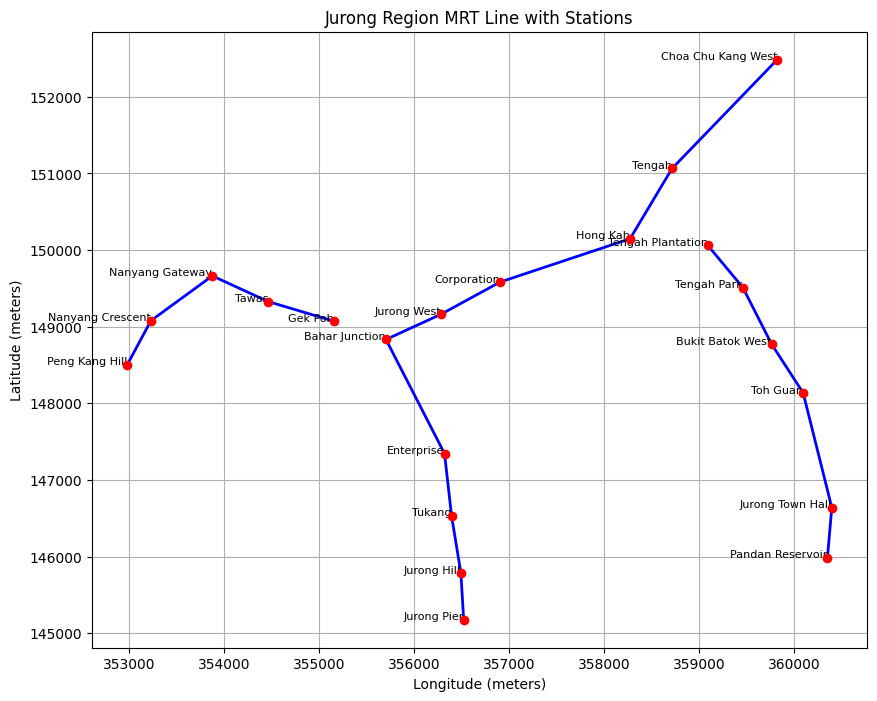

In [43]:
target_line = "Jurong Region" #change accordingly

# Check if the line exists in the processed data
if target_line in line_strings_per_station_line:
    if len(line_strings_per_station_line[target_line]) == 1:
        line_data = line_strings_per_station_line[target_line][0]
        
        # Extract the LineString, station points, and station names
        mrt_line = line_data['LineString']
        station_points = line_data['StationPoints']
        station_names = line_data['StationNames']

        # Plot the MRT line
        plt.figure(figsize=(10, 8))
        
        # Plot the LineString representing the MRT line
        x, y = mrt_line.xy  # Extract x and y coordinates from the LineString
        plt.plot(x, y, label=f'{target_line} Line', color='blue', linewidth=2)
        
        # Plot the station points on the map
        station_x = [point.x for point in station_points]
        station_y = [point.y for point in station_points]
        plt.scatter(station_x, station_y, color='red', label='Stations', zorder=5)

        # Annotate the station names
        for i, name in enumerate(station_names):
            plt.text(station_x[i], station_y[i], name, fontsize=8, ha='right')

        # Set the title and labels
        plt.title(f'{target_line} MRT Line with Stations')
        plt.xlabel('Longitude (meters)')
        plt.ylabel('Latitude (meters)')
        
        # Add a legend
        plt.legend()
        
        # Show the plot
        plt.grid(True)
        plt.show()

    elif len(line_strings_per_station_line[target_line]) >= 1:
        # Plot the MRT line (base plot)
        plt.figure(figsize=(10, 8))
            
        for i in range(len(line_strings_per_station_line[target_line])):
            line_data = line_strings_per_station_line[target_line][i]

            # Extract the LineString, station points, and station names
            mrt_line = line_data['LineString']
            station_points = line_data['StationPoints']
            station_names = line_data['StationNames']
            
            # Plot the LineString representing the MRT line
            x, y = mrt_line.xy  # Extract x and y coordinates from the LineString
            plt.plot(x, y, color='blue', linewidth=2)
            
            # Plot the station points on the map
            station_x = [point.x for point in station_points]
            station_y = [point.y for point in station_points]
            plt.scatter(station_x, station_y, color='red', label='Stations', zorder=5)

            # Annotate the station names
            for j, name in enumerate(station_names):
                plt.text(station_x[j], station_y[j], name, fontsize=8, ha='right')

        # Set the title and labels
        plt.title(f'{target_line} MRT Line with Stations')
        plt.xlabel('Longitude (meters)')
        plt.ylabel('Latitude (meters)')
        
        # Show the plot
        plt.grid(True)
        plt.show()

else:
    print(f"No data available for MRT Line: {target_line}")


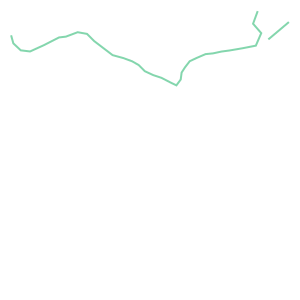

In [86]:
## Create Linestring for MRT without station info
mrt_linestrings_only = {}
for line_name, line_data in line_strings_per_station_line.items():
    if len(line_strings_per_station_line[line_name]) == 1:
        mrt_line = line_data[0]['LineString']
        mrt_linestrings_only[line_name] = mrt_line  # Store the line

    elif len(line_strings_per_station_line[line_name]) >= 1:

        all_lines = [line_data[i]['LineString'] for i in range(len(line_strings_per_station_line[line_name]))]
        # Union all LineStrings into a single geometry
        combined_mrt_line = unary_union(all_lines)
        mrt_linestrings_only[line_name] = combined_mrt_line # Store the combined line

mrt_linestrings_only['East-West']

# Segment MRT Stations

In [ ]:
# Function to segment a LineString into 1 km sections
def segment_line_by_distance(line, distance=1000):
    segments = []  # List to store the line segments
    current_distance = 0  # Start distance

    # Iterate over the entire length of the line and create segments of the specified distance
    while current_distance < line.length:
        # Calculate the start and end points for each segment
        start_point = line.interpolate(current_distance)
        end_point = line.interpolate(min(current_distance + distance, line.length))
        
        # Create a LineString for the segment and add it to the list
        segments.append(LineString([start_point, end_point]))
        
        # Move to the next segment
        current_distance += distance

    return segments  # Return the list of 1 km line segments

# Dictionary to store segmented lines for each MRT line
segmented_lines_per_station_line = {}

# Iterate through each MRT line in the dataset
for line_name, line_info in line_strings_per_station_line.items():
    if len(line_strings_per_station_line[line_name]) == 1:
        # Get the LineString and station details for each line
        mrt_line = line_info[0]['LineString']
        station_points = line_info[0]['StationPoints']
        station_names = line_info[0]['StationNames']

        # Segment the MRT line into 1 km sections
        mrt_segments = segment_line_by_distance(mrt_line, 1000)
        segmented_lines_per_station_line[line_name] = []

        # Store the segments for this MRT line
        segmented_lines_per_station_line[line_name].append({
            'segments': mrt_segments,
            'station_names': station_names,
            'station_points': station_points
        })

    elif len(line_strings_per_station_line[line_name]) >= 1:
        segmented_lines_per_station_line[line_name] = []
        
        for i in range(len(line_strings_per_station_line[line_name])):
            # Get the LineString and station details for each line
            mrt_line = line_info[i]['LineString']
            station_points = line_info[i]['StationPoints']
            station_names = line_info[i]['StationNames']

            # Segment the MRT line into 1 km sections
            mrt_segments = segment_line_by_distance(mrt_line, 1000)
            

            # Store the segments for this MRT line
            segmented_lines_per_station_line[line_name].append({
                'segments': mrt_segments,
                'station_names': station_names,
                'station_points': station_points
            })

segmented_lines_per_station_line['Jurong Region']

# Visualise MRT Segments

In [ ]:
len(segmented_lines_per_station_line['North-South'])
segmented_lines_per_station_line['North-South'][0]

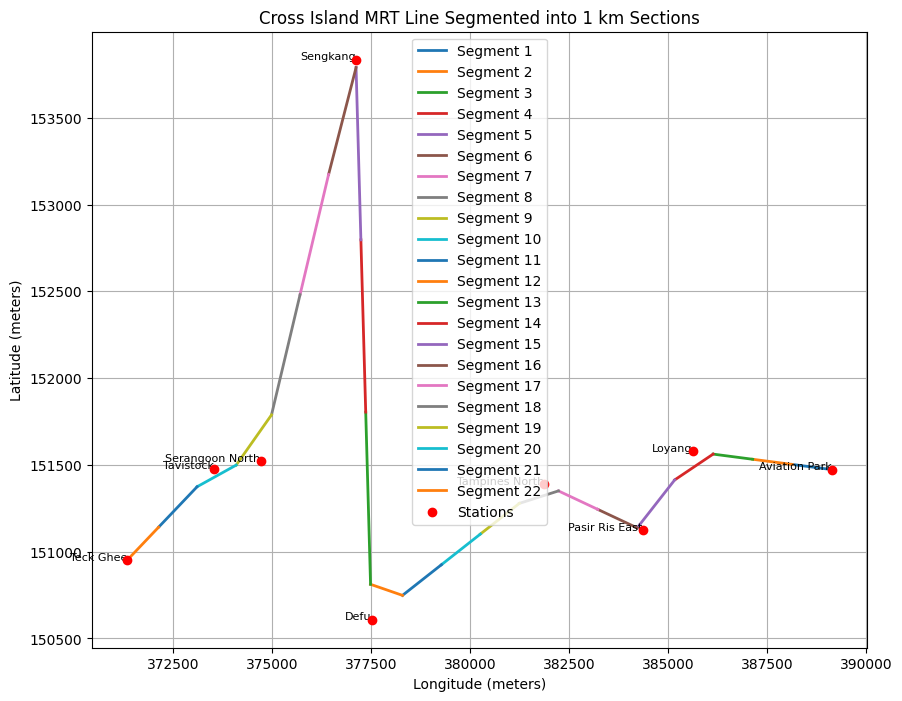

Segment 1: LINESTRING (389141.91449312423 151472.8716623472, 388142.3571785767 151502.62355194383)
Segment 2: LINESTRING (388142.3571785767 151502.62355194383, 387142.7998640292 151532.37544154047)
Segment 3: LINESTRING (387142.7998640292 151532.37544154047, 386143.2425494817 151562.12733113713)
Segment 4: LINESTRING (386143.2425494817 151562.12733113713, 385172.19282116694 151413.36800823745)
Segment 5: LINESTRING (385172.19282116694 151413.36800823745, 384223.99837121664 151137.0308300434)


In [77]:
target_line = "Cross Island"  # change to visualize other lines
if target_line in segmented_lines_per_station_line:
    if len(segmented_lines_per_station_line[target_line]) == 1:
        segmented_data = segmented_lines_per_station_line[target_line][0]

        mrt_segments = segmented_data['segments']
        station_points = segmented_data['station_points']
        station_names = segmented_data['station_names']

        # Visualize the segments on the map
        plt.figure(figsize=(10, 8))

        # Plot each segment in a different color
        for idx, segment in enumerate(mrt_segments):
            x_seg, y_seg = segment.xy  # Extract x and y coordinates for the segment
            plt.plot(x_seg, y_seg, label=f'Segment {idx+1}', linewidth=2)

        # Plot the station points
        station_x = [point.x for point in station_points]
        station_y = [point.y for point in station_points]
        plt.scatter(station_x, station_y, color='red', label='Stations', zorder=5)

        # Annotate the station names
        for i, name in enumerate(station_names):
            plt.text(station_x[i], station_y[i], name, fontsize=8, ha='right')

        # Set the title and labels
        plt.title(f'{target_line} MRT Line Segmented into 1 km Sections')
        plt.xlabel('Longitude (meters)')
        plt.ylabel('Latitude (meters)')

        # Add a legend
        plt.legend()
        
        # Show the plot
        plt.grid(True)
        plt.show()

        # Print the first few segments for verification
        for idx, segment in enumerate(mrt_segments[:5]):  # Print first 5 segments
            print(f"Segment {idx+1}: {segment}")


    elif len(segmented_lines_per_station_line[target_line]) >= 1:
        # Base Map
        plt.figure(figsize=(10, 8))

        for i in range(len(segmented_lines_per_station_line[target_line])):
            segmented_data = segmented_lines_per_station_line[target_line][i]

            mrt_segments = segmented_data['segments']
            station_points = segmented_data['station_points']
            station_names = segmented_data['station_names']

            # Plot each segment in a different color
            for idx, segment in enumerate(mrt_segments):
                x_seg, y_seg = segment.xy  # Extract x and y coordinates for the segment
                plt.plot(x_seg, y_seg, label=f'Segment {idx+1}', linewidth=2)

            # Plot the station points
            station_x = [point.x for point in station_points]
            station_y = [point.y for point in station_points]
            plt.scatter(station_x, station_y, color='red', label='Stations', zorder=5)

            # Annotate the station names
            for j, name in enumerate(station_names):
                plt.text(station_x[j], station_y[j], name, fontsize=8, ha='right')

        # Set the title and labels
        plt.title(f'{target_line} MRT Line Segmented into 1 km Sections')
        plt.xlabel('Longitude (meters)')
        plt.ylabel('Latitude (meters)')

        # Add a legend
        plt.legend()
        
        # Show the plot
        plt.grid(True)
        plt.show()

        # Print the first few segments for verification
        for idx, segment in enumerate(mrt_segments[:5]):  # Print first 5 segments
            print(f"Segment {idx+1}: {segment}")

else:
    print(f"No data available for MRT Line: {target_line}")

# PHASE 1: Conduct Initial Checks for Distance Proximity
Compare the bus route's entire geometry with the MRT line to check if they are near in distance. If there's no overlap, discard that bus route.
Reduces the number of comparisons needed.

In [58]:
# Define buffer distance
buffer_distance = 500

In [ ]:
if bus_routes_lines.crs is None:
    bus_routes_lines = bus_routes_lines.set_crs(epsg=4326)

#Reproject bus routes to the same CRS as the MRT lines (UTM Zone 48N - EPSG:32648)
bus_routes_lines = bus_routes_lines.to_crs(epsg=32648)

mrt_buffers = {}  # Dictionary to store buffers for each MRT line

for line_name, line_data in line_strings_per_station_line.items():
    if len(line_strings_per_station_line[line_name]) == 1:
        mrt_line = line_data[0]['LineString']
        mrt_buffer = mrt_line.buffer(buffer_distance)  # Create a buffer around the MRT line
        mrt_buffers[line_name] = mrt_buffer  # Store the buffer

    elif len(line_strings_per_station_line[line_name]) >= 1:

        all_lines = [line_data[i]['LineString'] for i in range(len(line_strings_per_station_line[line_name]))]
    
        # Union all LineStrings into a single geometry
        combined_mrt_line = unary_union(all_lines)
        
        mrt_buffer = combined_mrt_line.buffer(buffer_distance)  # Create a buffer around the MRT line
        mrt_buffers[line_name] = mrt_buffer  # Store the buffer


#Check if any bus route is near any MRT line buffer
overlap_results = []

for line_name, mrt_buffer in mrt_buffers.items():
    for idx, bus_route in bus_routes_lines.iterrows():
        if bus_route.geometry.intersects(mrt_buffer):
            overlap_length = bus_route.geometry.intersection(mrt_buffer).length  # Get overlap length
            overlap_results.append({
                'MRT_Line': line_name,
                'Bus_ServiceNo': bus_route['ServiceNo'],
                'Bus_Route_Length_m': bus_route.geometry.length,  # Length of the bus route in meters
                'Overlap_Length_m': overlap_length  # Overlap length in meters
            })

overlap_df = pd.DataFrame(overlap_results)

#Sort the DataFrame by 'Overlap_Length_m' in descending order
overlap_df_sorted = overlap_df.sort_values(by='Overlap_Length_m', ascending=False)

# For each bus service, keep only the direction with the greater overlap
# Group by 'Bus_ServiceNo' and 'Direction', take the max 'Overlap_Length_m' for each service
overlap_df_max = overlap_df_sorted.groupby(['Bus_ServiceNo']).apply(lambda x: x.loc[x['Overlap_Length_m'].idxmax()]).reset_index(drop=True)

# Drop duplicates for each 'Bus_ServiceNo' while keeping only the row with the maximum 'Overlap_Length_m'
overlap_df_unique = overlap_df_max.sort_values(by='Overlap_Length_m', ascending=False).drop_duplicates(subset=['Bus_ServiceNo'], keep='first')

# Output the final DataFrame
overlap_df_unique



/var/folders/hx/j3t1dc5d6539d5c6zm67rnf00000gn/T/ipykernel_71113/4160999724.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overlap_df_max = overlap_df_sorted.groupby(['Bus_ServiceNo']).apply(lambda x: x.loc[x['Overlap_Length_m'].idxmax()]).reset_index(drop=True)


,MRT_Line,Bus_ServiceNo,Bus_Route_Length_m,Overlap_Length_m
340,East-West,63,33442.621667,22452.059977
268,Thomson East Coast,36,44616.364459,22222.688024
187,East-West,24,45129.781783,21884.822077
372,Circle,70M,39038.921802,21335.866347
309,East-West,502,48413.868050,20724.611092
...,...,...,...,...
465,Thomson East Coast,902,551.485014,551.485014
192,East-West,241A,2021.609182,504.937715
264,East-West,354,3490.072688,466.927813
506,North-South,962C,1250.818701,402.658208


# PHASE 2.1: Segment Coverage Calculation for Bus Routes and MRT Line Segments
To determine how much of an MRT line's segments are covered by a bus route. The MRT lines are segmented into equal parts, and we check which of these segments overlap with the corresponding bus route. This analysis helps us assess how parallel the bus route is to the MRT line in terms of spatial coverage.

Steps:

Segmentation: Each MRT line is divided into segments of a fixed length. These segments represent portions of the MRT line.

Intersection Check: For each bus route, we check how many of the MRT segments it intersects. This is done by comparing the geometry of the bus route with each MRT segment.

Coverage Calculation: We calculate the percentage of MRT segments that are covered by the bus route:

In [87]:
# Initialize a list to store the results
segment_coverage_results = []

# Iterate through each row in overlap_df_unique
for idx, row in overlap_df_unique.iterrows():
    # Fetch the geometry of the bus route (LineString) based on ServiceNo and Direction
    bus_geometry = bus_routes_lines.loc[
        (bus_routes_lines['ServiceNo'] == row['Bus_ServiceNo'])
    ].geometry.iloc[0]
    
    # Fetch the MRT Line geometry
    mrt_line = mrt_linestrings_only[row['MRT_Line']]
    
    # Segment the MRT line 
    mrt_segments = segment_line_by_distance(mrt_line, 1000)  # EDIT

    # Calculate how many segments are covered by the bus route
    total_segments = len(mrt_segments)
    covered_segments = 0

    for segment in mrt_segments:
        if bus_geometry.intersects(segment):  # Check if the bus route intersects the MRT segment
            covered_segments += 1

    # Calculate the percentage of MRT segments covered by the bus route
    coverage_percentage = (covered_segments / total_segments) * 100 if total_segments > 0 else 0
    
    # Append the result to the list
    segment_coverage_results.append({
        'MRT_Line': row['MRT_Line'],
        'Bus_ServiceNo': row['Bus_ServiceNo'],
        'Bus_Route_Length_m': row['Bus_Route_Length_m'],
        'Overlap_Length_m': row['Overlap_Length_m'],
        'Coverage_Percentage': coverage_percentage
    })

# Convert the results to a DataFrame
segment_coverage_df = pd.DataFrame(segment_coverage_results)

# Filter the DataFrame to only include rows with a Coverage_Percentage > 0
segment_coverage_df_filtered = segment_coverage_df[segment_coverage_df['Coverage_Percentage'] > 0]

# Sort by coverage percentage in descending order
segment_coverage_df_sorted = segment_coverage_df_filtered.sort_values(by='Coverage_Percentage', ascending=False)

# Output the final DataFrame
segment_coverage_df_sorted

,MRT_Line,Bus_ServiceNo,Bus_Route_Length_m,Overlap_Length_m,Coverage_Percentage
144,Bukit Panjang LRT,976,7464.432230,7163.349917,50.000000
184,Bukit Panjang LRT,975,33732.482499,6302.597549,50.000000
387,Bukit Panjang LRT,975C,16980.660182,3204.258895,50.000000
69,Bukit Panjang LRT,972M,36598.676848,9644.545486,50.000000
169,Punggol LRT,386,7031.400729,6580.084392,50.000000
...,...,...,...,...,...
229,East-West,35M,14598.777922,5502.529997,1.960784
323,East-West,292,4845.120281,4216.571620,1.960784
475,East-West,21A,3062.016658,1742.472011,1.960784
348,East-West,240M,5113.814265,3722.431779,1.960784


# Phase 2.2 Bus Segments with MRT Line String

The method below segments the bus routes and checks how many consecutive bus segments overlap with the MRT LineString. It also tracks percentage of bus segments that are intersecting with the MRT Linestring in a similar concept to the code above.
This method is in consideration of routes that are not always intersecting with the MRT (like the example given in consult) and hence should not be counted as parallel.

In [89]:
# Initialize a list to store the results
bus_segments_results = []

# Iterate through each row in the overlap DataFrame
for idx, row in overlap_df_unique.iterrows():
    # Fetch the geometry of the bus route based on ServiceNo
    bus_geometry = bus_routes_lines.loc[
        (bus_routes_lines['ServiceNo'] == row['Bus_ServiceNo'])
    ].geometry.iloc[0]
    
    # Fetch the MRT line geometry
    mrt_line = mrt_linestrings_only[row['MRT_Line']]
    
    # Segment the bus route into 1 km sections
    bus_segments = segment_line_by_distance(bus_geometry, 1000)

    # Initialize variables to track intersections and consecutive streaks
    total_segments = len(bus_segments)
    max_consecutive = 0
    current_consecutive = 0
    total_intersecting_segments = 0

    # Iterate over the bus segments and check for intersections with the MRT line
    for segment in bus_segments:
        if mrt_line.intersects(segment):  # If the segment intersects
            current_consecutive += 1  # Increment the consecutive count
            total_intersecting_segments += 1  # Track the total intersections
        else:
            max_consecutive = max(max_consecutive, current_consecutive)  # Track the max streak
            current_consecutive = 0  # Reset the consecutive count

    # Ensure the last streak is recorded
    max_consecutive = max(max_consecutive, current_consecutive)

    # Calculate the percentage of total segments in the longest streak
    consecutive_coverage = (max_consecutive / total_segments) * 100 if total_segments > 0 else 0
    total_segment_perc = (total_intersecting_segments/total_segments)* 100 if total_segments > 0 else 0
    # Append the result to the list
    bus_segments_results.append({
        'MRT_Line': row['MRT_Line'],
        'Bus_ServiceNo': row['Bus_ServiceNo'],
        'Bus_Route_Length_m': row['Bus_Route_Length_m'],
        'Overlap_Length_m': row['Overlap_Length_m'],
        'Intersecting_Segments_Percentage': total_segment_perc,
        'Consecutive_Coverage_Percentage': consecutive_coverage,
        'Max_Consecutive_Segments': max_consecutive
        # 'Frechet Distance': frechet_distance
    })

# Convert the results into a DataFrame
bus_segments_df = pd.DataFrame(bus_segments_results)

# Filter to include only meaningful overlaps
bus_segments_df_filtered = bus_segments_df[bus_segments_df['Intersecting_Segments_Percentage'] > 0]

# Sort by total intersecting segments and then consecutive coverage percentage
bus_segments_df_sorted = bus_segments_df_filtered.sort_values(
    by=['Intersecting_Segments_Percentage', 'Consecutive_Coverage_Percentage'], 
    ascending=[False, False]
)

# Output the final DataFrame
print(bus_segments_df_sorted.head(5))

              MRT_Line Bus_ServiceNo  Bus_Route_Length_m  Overlap_Length_m  \
464        North-South          302A         1929.302493       1929.302493   
504  Bukit Panjang LRT          973A         1249.539533       1249.539533   
188       Sengkang LRT           374         6668.132696       6223.689276   
323          East-West           292         4845.120281       4216.571620   
277             Circle            91         4749.668387       4749.668387   

     Intersecting_Segments_Percentage  Consecutive_Coverage_Percentage  \
464                        100.000000                       100.000000   
504                        100.000000                       100.000000   
188                         85.714286                        85.714286   
323                         80.000000                        60.000000   
277                         80.000000                        40.000000   

     Max_Consecutive_Segments  
464                         2  
504                   

In [90]:
# Merge the new bus segments intersection results with the existing coverage DataFrame
phase2_df = pd.merge(
    segment_coverage_df_sorted,  # DataFrame from phase 2.1
    bus_segments_df_sorted,  # DataFrame from phase 2.2 (bus segments)
    on=['MRT_Line', 'Bus_ServiceNo'],  # Merge on common columns
    how='left'  # Keep all rows from phase 2.1 and match with 2.2 results
)
phase2_df.drop(columns=['Bus_Route_Length_m_y', 'Overlap_Length_m_y', 'Intersecting_Segments_Percentage'], inplace=True)
phase2_df.rename(columns={'Bus_Route_Length_m_x': 'Bus_Route_Length_m', 
                          'Overlap_Length_m_x': 'Overlap_Length_m'},
                          inplace=True)
# Output the merged DataFrame
print(phase2_df.head(10))


            MRT_Line Bus_ServiceNo  Bus_Route_Length_m  Overlap_Length_m  \
0  Bukit Panjang LRT           976         7464.432230       7163.349917   
1  Bukit Panjang LRT           975        33732.482499       6302.597549   
2  Bukit Panjang LRT          975C        16980.660182       3204.258895   
3  Bukit Panjang LRT          972M        36598.676848       9644.545486   
4        Punggol LRT           386         7031.400729       6580.084392   
5       Sengkang LRT           163        17724.889316       4570.671515   
6       Sengkang LRT           374         6668.132696       6223.689276   
7       Sengkang LRT          163B         8132.129364       4570.671515   
8       Sengkang LRT           50A        10289.612183       4556.260336   
9       Sengkang LRT          163A         4950.535254       4570.671515   

   Coverage_Percentage  Consecutive_Coverage_Percentage  \
0            50.000000                        37.500000   
1            50.000000                       

# Phase 3: Weighted Average Angle of Deviation

This phase aims to assess how parallel bus routes are to MRT segments by calculating the weighted average angle of deviation. The angle is computed between vectors representing each MRT segment and the nearest point on the bus route. Smaller angles indicate closer alignment, suggesting the bus route runs more parallel to the MRT line. The weighted average considers segment lengths, providing a comprehensive measure of overall parallelism. This metric helps to identify potential overlaps and redundancies between bus and MRT services.

In [91]:
# Function to calculate angle between two vectors
def calculate_angle(vector1, vector2):
    # Normalize the vectors to avoid issues with length differences
    vector1 = vector1 / np.linalg.norm(vector1)
    vector2 = vector2 / np.linalg.norm(vector2)

    # Calculate the angle in radians and convert to degrees
    cos_angle = np.dot(vector1, vector2)
    # To prevent possible floating-point inaccuracies that can result in a domain error
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle = np.degrees(np.arccos(cos_angle))
    return angle

In [93]:
# Suppress the specific warning
warnings.filterwarnings("ignore", message="invalid value encountered in line_locate_point")

# Initialize a list to store the results
segment_coverage_results = []

# Iterate through each row in overlap_df_unique
for idx, row in overlap_df_unique.iterrows():
    # Fetch the geometry of the bus route (LineString) based on ServiceNo and Direction
    bus_geometry = bus_routes_lines.loc[
        (bus_routes_lines['ServiceNo'] == row['Bus_ServiceNo'])
    ].geometry.iloc[0]
    
    # Ensure bus geometry is valid
    if not bus_geometry.is_valid:
        bus_geometry = make_valid(bus_geometry)

    # Fetch the MRT Line geometry and segment it
    mrt_line = mrt_linestrings_only[row['MRT_Line']]
    if not mrt_line.is_valid:
        mrt_line = make_valid(mrt_line)
    
    mrt_segments = segment_line_by_distance(mrt_line, 1000)

    # Initialize variables to calculate the weighted average angle
    weighted_sum_angle = 0
    total_weight = 0

    # Calculate the angle for each MRT segment and find the closest point on the bus route
    for segment in mrt_segments:
        if not segment.is_valid:
            segment = make_valid(segment)
        
        midpoint = segment.interpolate(0.5, normalized=True)  # Calculate the midpoint of the MRT segment
        try:
            closest_point = bus_geometry.interpolate(bus_geometry.project(midpoint))
        except:
            continue  # Skip this segment if there's an error in projecting
        
        # Create vectors from segment start to end and from midpoint to closest point
        mrt_vector = [segment.coords[-1][0] - segment.coords[0][0], segment.coords[-1][1] - segment.coords[0][1]]
        bus_vector = [closest_point.x - midpoint.x, closest_point.y - midpoint.y]

        # Normalize the vectors
        mrt_vector = np.array(mrt_vector) / np.linalg.norm(mrt_vector)
        bus_vector = np.array(bus_vector) / np.linalg.norm(bus_vector)

        # Calculate angle using dot product (ignoring direction)
        dot_product = np.dot(mrt_vector, bus_vector)
        dot_product = np.clip(dot_product, -1.0, 1.0)  # To avoid numerical errors outside the valid range
        angle = np.degrees(np.arccos(abs(dot_product)))  # Use absolute value to ignore direction

        # Update weighted sum and total weight using segment length 
        segment_length = segment.length
        weighted_sum_angle += angle * segment_length
        total_weight += segment_length

    # Calculate the weighted average angle
    weighted_average_angle = (weighted_sum_angle / total_weight) if total_weight > 0 else 0  
    
    segment_coverage_results.append({
        'MRT_Line': row['MRT_Line'],
        'Bus_ServiceNo': row['Bus_ServiceNo'],
        'Weighted_Average_Angle': round(weighted_average_angle, 1)
    })

# Convert to DataFrame and merge with existing data
angles_df = pd.DataFrame(segment_coverage_results)
# angles_df_merged = pd.merge(segment_coverage_df_sorted, angles_df, on=['MRT_Line', 'Bus_ServiceNo'], how='left')

angles_df


,MRT_Line,Bus_ServiceNo,Weighted_Average_Angle
0,East-West,63,56.0
1,Thomson East Coast,36,46.7
2,East-West,24,35.9
3,Circle,70M,51.4
4,East-West,502,58.6
...,...,...,...
551,Thomson East Coast,902,39.2
552,East-West,241A,17.8
553,East-West,354,27.5
554,North-South,962C,34.1


In [94]:
# Code to join weighted average angle onto phase 2 final df >> phase 3 df 
phase3_df = pd.merge(
    phase2_df,  # DataFrame from phase 2.1 and 2.2
    angles_df,
    on=['MRT_Line', 'Bus_ServiceNo'],  # Merge on common columns
    how='left'  # Keep all rows from phase 2.1 and match with 2.2 results
)

# Output the merged DataFrame
print(phase3_df.head(10))

            MRT_Line Bus_ServiceNo  Bus_Route_Length_m  Overlap_Length_m  \
0  Bukit Panjang LRT           976         7464.432230       7163.349917   
1  Bukit Panjang LRT           975        33732.482499       6302.597549   
2  Bukit Panjang LRT          975C        16980.660182       3204.258895   
3  Bukit Panjang LRT          972M        36598.676848       9644.545486   
4        Punggol LRT           386         7031.400729       6580.084392   
5       Sengkang LRT           163        17724.889316       4570.671515   
6       Sengkang LRT           374         6668.132696       6223.689276   
7       Sengkang LRT          163B         8132.129364       4570.671515   
8       Sengkang LRT           50A        10289.612183       4556.260336   
9       Sengkang LRT          163A         4950.535254       4570.671515   

   Coverage_Percentage  Consecutive_Coverage_Percentage  \
0            50.000000                        37.500000   
1            50.000000                       

# Final Scoring System for Identifying Parallel Routes
In this section, we consolidate all the analyses conducted in previous phases to form a comprehensive scoring system. The final DataFrame (phase3_df) includes critical metrics such as coverage percentage, segment intersections, consecutive coverage, and weighted average angle to determine how well each bus route aligns with the MRT lines.

These metrics are used to systematically evaluate and score parallel routes, allowing us to narrow down on the routes for further evaluation, planning, and studying ridership patterns. The resulting scoring system provides an objective measure for route similarity, facilitating better optimization of public transit services.

In [96]:
# final scores + rank them

# Calculate the weighted average score
phase3_df['Weighted_Average_Score'] = (
    phase3_df['Coverage_Percentage'] * 0.4 +
    phase3_df['Consecutive_Coverage_Percentage'] * 0.4 +
    phase3_df['Weighted_Average_Angle'] * 0.2
)

final_df = phase3_df.sort_values(by=['Weighted_Average_Score'], ascending=False)
# final_df = final_df[~final_df['MRT_Line'].str.contains("LRT") \
#                     & (final_df['MRT_Line'].str.contains("Jurong Region") \
#                     | final_df['MRT_Line'].str.contains("Cross Island") \
#                     | final_df['MRT_Line'].str.contains("Thomson East Coast"))]

In [97]:
final_df[:20]

,MRT_Line,Bus_ServiceNo,Bus_Route_Length_m,Overlap_Length_m,Coverage_Percentage,Consecutive_Coverage_Percentage,Max_Consecutive_Segments,Weighted_Average_Angle,Weighted_Average_Score
6,Sengkang LRT,374,6668.132696,6223.689276,42.857143,85.714286,6.0,65.3,64.488571
60,Bukit Panjang LRT,973A,1249.539533,1249.539533,16.666667,100.000000,2.0,30.7,52.806667
330,North-South,302A,1929.302493,1929.302493,4.761905,100.000000,2.0,40.4,49.984762
0,Bukit Panjang LRT,976,7464.432230,7163.349917,50.000000,37.500000,3.0,59.1,46.820000
86,Sengkang LRT,371,3670.834138,3415.385146,14.285714,75.000000,3.0,42.8,44.274286
20,Bukit Panjang LRT,974A,17749.950298,6847.603315,33.333333,38.888889,7.0,62.5,41.388889
19,Bukit Panjang LRT,922,7119.814773,7119.814773,33.333333,50.000000,4.0,39.6,41.253333
4,Punggol LRT,386,7031.400729,6580.084392,50.000000,25.000000,2.0,43.1,38.620000
15,Punggol LRT,83T,5486.421431,3593.028154,33.333333,33.333333,2.0,56.8,38.026667
9,Sengkang LRT,163A,4950.535254,4570.671515,42.857143,20.000000,1.0,64.3,38.002857


In [55]:
final_df.to_csv('data/cleaned/BusMRTOverlap.csv', index=False)